# Prelims

In [1]:
!pip3 install os
!pip3 install --upgrade torch
!pip3 install matplotlib
!pip3 install torch torchvision
!pip3 install torchtext spacy
!pip3 install --upgrade pip
!pip3 install seaborn
!python -m spacy download en 
!python -m spacy download fr 

  Could not find a version that satisfies the requirement os (from versions: )
No matching distribution found for os
Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.0.0)
Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (18.1)

    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en

    You can now load the model via spacy.load('en')


    Linking successful
    /usr/local/lib/python3.6/dist-packages/fr_core_news_sm -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/fr

    You can now load the model via spacy.load('fr')



In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
device = torch.device(torch.cuda.current_device())

# Model Architecture

## Encoder

In [0]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator

    def forward(self, src, tgt, src_mask, tgt_mask):
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)

    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)


class Generator(nn.Module):
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)


def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


class Encoder(nn.Module):
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

    
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2


class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))


class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)



## Decoder

In [0]:
class Decoder(nn.Module):
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)


class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)

    def forward(self, x, memory, src_mask, tgt_mask):
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)


def subsequent_mask(size):
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0


# Attention

In [0]:
def attention(query, key, value, mask=None, dropout=None):
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn


In [0]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        if mask is not None:
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        query, key, value = [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2) for l, x in zip(self.linears, (query, key, value))]
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)


# Position-wise Feed-Forward Networks

In [0]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))



# Embeddings and Softmax

In [0]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)


# Positional Encoding

In [0]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)


# Full Model

In [0]:
def make_model(src_vocab, tgt_vocab, N=6, d_model=256, d_ff=512, h=4, dropout=0.1):
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
                           Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
                           nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
                           nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
                           Generator(d_model, tgt_vocab))
    # This was important from their code.
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model


# Training

## Batches and Masking

In [0]:
class Batch:
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()

    @staticmethod
    def make_std_mask(tgt, pad):
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask
        
def rebatch(pad_idx, batch):
    "Fix order in torchtext to match ours"
    src, trg = batch.src.transpose(0, 1), batch.trg.transpose(0, 1)
    return Batch(src, trg, pad_idx)


## Training Loop

In [0]:
def run_epoch(data_iter, model, loss_compute, maxItNb):
    "Standard Training and Logging Function"
    total_tokens = 0
    total_loss = 0
    lossArray = [] 
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg, 
                            batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens.float()
        print('\nEpoch ', i, 'loss ', loss/batch.ntokens.float())
        lossArray.append(loss/batch.ntokens.float())
        if i >= maxItNb : 
            break
    tot = total_loss / total_tokens
    return tot, lossArray

global max_src_in_batch, max_tgt_in_batch


def batch_size_fn(new, count, sofar):
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

## Optimizer

In [0]:
class NoamOpt:
    """
    l_rate = d_model^(−0.5) * min(step_num^(−0.5), step_num * warmup_steps^(−1.5))
    """
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0

    def step(self):
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()

    def rate(self, step=None):
        if step is None:
            step = self._step
        return self.factor * (self.model_size ** (-0.5) * min(step ** (-0.5), step * self.warmup ** (-1.5)))


def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 8000, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

def loadModel(path, SRC, TGT, device):
    state = torch.load(path, map_location=device)
    print(state)
    model = make_model(len(SRC.vocab), len(TGT.vocab))
    model.load_state_dict(state['state_dict'])
    batchSize = state['batchSize']
    epoch = state['epoch']
    return model,batchSize,epoch


# Data loader

In [0]:
from torchtext import data, datasets
import spacy

def loadDataIWLST():
    print("Doing spacy load")
    spacy_fr = spacy.load('fr')
    spacy_en = spacy.load('en')
    print("Spacy load completed")

    def tokenize_fr(text):
        return [tok.text for tok in spacy_fr.tokenizer(text)]

    def tokenize_en(text):
        return [tok.text for tok in spacy_en.tokenizer(text)]
    
    print("Creating data Fields")
    BOS_WORD = '<s>'
    EOS_WORD = '</s>'
    BLANK_WORD = "<blank>"
    SRC = data.Field(tokenize=tokenize_fr, pad_token=BLANK_WORD)
    TGT = data.Field(tokenize=tokenize_en, init_token = BOS_WORD, 
                     eos_token = EOS_WORD, pad_token=BLANK_WORD)
    
    MAX_LEN = 100

    print("Splitting")
    train, val, test = datasets.IWSLT.splits(
        exts=('.fr', '.en'), fields=(SRC, TGT), 
        filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and 
            len(vars(x)['trg']) <= MAX_LEN)
    MIN_FREQ = 2

    print("Building vocabulary")
    SRC.build_vocab(train.src, min_freq=MIN_FREQ)
    TGT.build_vocab(train.trg, min_freq=MIN_FREQ)

    pad_idx = TGT.vocab.stoi[BLANK_WORD]

    return SRC,TGT,train,val,test, pad_idx


## Loading


In [0]:
justEvaluate = False
loadPreTrain = False
trainItNb = 2000
validItNb = 100
BATCH_SIZE = 80
validFreq = 5
previousEpochNb = 0
modelSavePath = "Model/modelIWSLT.nn"
testSentence = """Il y a un secret pour travailler avec les entrepreneurs ."""
testTranslation = """There is a secret for working with entrepreneurs ."""

In [16]:

"""**Load Data **"""

#Load Data
print("Loading Data")
SRC,TGT,train,val,test, pad_idx = loadDataIWLST()
print("Data Loaded")


Loading Data
Doing spacy load
Spacy load completed
Creating data Fields
Splitting
Building vocabulary
Data Loaded


## Visualisation


In [0]:
"""Visualisation """
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")

def draw(data, x, y, ax):
    seaborn.heatmap(data.cpu(), 
                    xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0, 
                    cbar=False, ax=ax)
    #plt.imshow(data, cmap='hot', interpolation='nearest', vmin=0.0, vmax=1.0,)


## Load / Save Model

In [0]:
def saveModel(model,model_opt ,epoch, batchSize, PATH):
    state = {
    'epoch': epoch,
    'state_dict': model.state_dict(),
    'batchSize' : batchSize
    }
    torch.save(state, PATH)

def loadModel(PATH, SRC, TGT):
    state = torch.load(PATH)
    
    model = make_model(len(SRC.vocab), len(TGT.vocab))
    model.load_state_dict(state['state_dict'])
    
    batchSize = state['batchSize']
    
    epoch = state['epoch']

    return model,batchSize,epoch


# Model Initialization 

In [19]:
if (loadPreTrain or justEvaluate) :
    print("Loading pre-trained network")
    model, BATCH_SIZE, previousEpochNb = loadModel(modelSavePath, SRC, TGT)
else :
    print("initializing network")
    model = make_model(len(SRC.vocab), len(TGT.vocab), N=6)
    
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 4000,
            torch.optim.Adam(filter(lambda x: x.requires_grad, model.parameters()), lr=0.001, betas=(0.9, 0.98), eps=1e-8))    
model.cuda()
criterion = nn.CrossEntropyLoss()



print("Initializing iterators")
train_iter = data.BucketIterator(train, batch_size=BATCH_SIZE, device=device, repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)), train=True)
valid_iter = data.BucketIterator(val, batch_size=BATCH_SIZE, device=device, repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)), train=False)



initializing network


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  from ipykernel import kernelapp as app


Initializing iterators


# Define Loss

In [0]:
"""**Define Loss**"""
class SingleGPULossCompute:
    "A single-gpu loss compute and train function."
    def __init__(self, generator, criterion, device, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        #self.device = device
        #self.chunk_size = chunk_size
        
    def __call__(self, x, y, norm):
        x = self.generator(x)
        norm = norm.float()
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.item() * norm.item()
        

# Greedy Decode

In [0]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len-1):
        out = model.decode(memory, src_mask, 
                           Variable(ys), 
                           Variable(subsequent_mask(ys.size(1))
                                    .type_as(src.data)))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        ys = torch.cat([ys, 
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys


# Train Definition 

In [0]:
def training(model, optimizer, trainItNb, train_iter, valid_iter, validFreq, criterion, pad_idx, device) :
    model.train()
    tot_loss, lossArray = run_epoch((rebatch(pad_idx, b) for b in train_iter), 
        model, 
        SingleGPULossCompute(model.generator, criterion, 
                             device=device, opt=optimizer), trainItNb)    
    iterations = range(0, len(lossArray))
    plt.figure(figsize=(21,7)) 
    plt.plot(iterations, lossArray, label = "training loss")
    plt.title('loss', fontsize=20)
    plt.show()
    plt.savefig('loss.svg')

# Evaluate Definition 

In [0]:
def evaluate(model, valid_iter, criterion, device, optimizer, pad_idx, validItNb) :
    model.eval()
    print(pad_idx)
    loss = run_epoch((rebatch(pad_idx, b) for b in valid_iter), 
                     model, 
                     SingleGPULossCompute(model.generator, criterion, 
                     device=device, opt=None), validItNb)
    print("loss : ", loss)
    
    """Translate default sentence"""
    print("Source:")
    print(testSentence)
    sent = testSentence.split()  
    src = torch.LongTensor([[SRC.vocab.stoi[w] for w in sent]])
    src = Variable(src).cuda()
    src_mask = (src != SRC.vocab.stoi["<blank>"]).unsqueeze(-2)
    out = greedy_decode(model, src, src_mask,max_len=60, 
                        start_symbol=TGT.vocab.stoi["<s>"])
    print("Translation:")
    trans = "<s> "
    for i in range(1, out.size(1)):
        sym = TGT.vocab.itos[out[0, i]]
        if sym == "</s>": break
        trans += sym + " "
    print(trans.encode("utf-8"))                   
    print("Target :")
    print(testTranslation)
    
    print("Plotting and exporting graphs")
    
    tgt_sent = trans.split()   
    print(len(tgt_sent))
    print(len(sent))
    
    for layer in range(1, 6, 2):
        num = str(layer+1)
        fig, axs = plt.subplots(1,4, figsize=(40, 20))
        print("Encoder Layer", layer+1)
        for h in range(4):
            draw(model.encoder.layers[layer].self_attn.attn[0, h].data[:len(sent), :len(sent)], 
                sent, sent if h ==0 else [], ax=axs[h])
        plt.show()
        plt.savefig('encoderlayer_' + num + ' .svg')

    for layer in range(1, 6, 2):
        num = str(layer+1)
        fig, axs = plt.subplots(1,4, figsize=(40, 20))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(model.decoder.layers[layer].self_attn.attn[0, h].data[:len(tgt_sent), :len(tgt_sent)], 
                tgt_sent, tgt_sent if h ==0 else [], ax=axs[h])
        plt.show()
        plt.savefig('DecoderSelfLayer_' + num + ' .svg')
    print("Decoder Src Layer", layer+1)
    fig, axs = plt.subplots(1,4, figsize=(40, 20))
    for h in range(4):
        draw(model.decoder.layers[layer].src_attn.attn[0, h].data[:len(tgt_sent), :len(sent)], 
            sent, tgt_sent if h ==0 else [], ax=axs[h])
    plt.show()
    plt.savefig('DecoderSrcLayer_' + num + ' .svg')


# Training

Starting training

Epoch  0 loss  tensor(0.0061, device='cuda:0')

Epoch  1 loss  tensor(0.0062, device='cuda:0')

Epoch  2 loss  tensor(0.0061, device='cuda:0')

Epoch  3 loss  tensor(0.0059, device='cuda:0')

Epoch  4 loss  tensor(0.0069, device='cuda:0')

Epoch  5 loss  tensor(0.0058, device='cuda:0')

Epoch  6 loss  tensor(0.0065, device='cuda:0')

Epoch  7 loss  tensor(0.0062, device='cuda:0')

Epoch  8 loss  tensor(0.0063, device='cuda:0')

Epoch  9 loss  tensor(0.0056, device='cuda:0')

Epoch  10 loss  tensor(0.0056, device='cuda:0')

Epoch  11 loss  tensor(0.0065, device='cuda:0')

Epoch  12 loss  tensor(0.0059, device='cuda:0')

Epoch  13 loss  tensor(0.0064, device='cuda:0')

Epoch  14 loss  tensor(0.0064, device='cuda:0')

Epoch  15 loss  tensor(0.0067, device='cuda:0')

Epoch  16 loss  tensor(0.0058, device='cuda:0')

Epoch  17 loss  tensor(0.0057, device='cuda:0')

Epoch  18 loss  tensor(0.0065, device='cuda:0')

Epoch  19 loss  tensor(0.0061, device='cuda:0')

Epoch  20 l

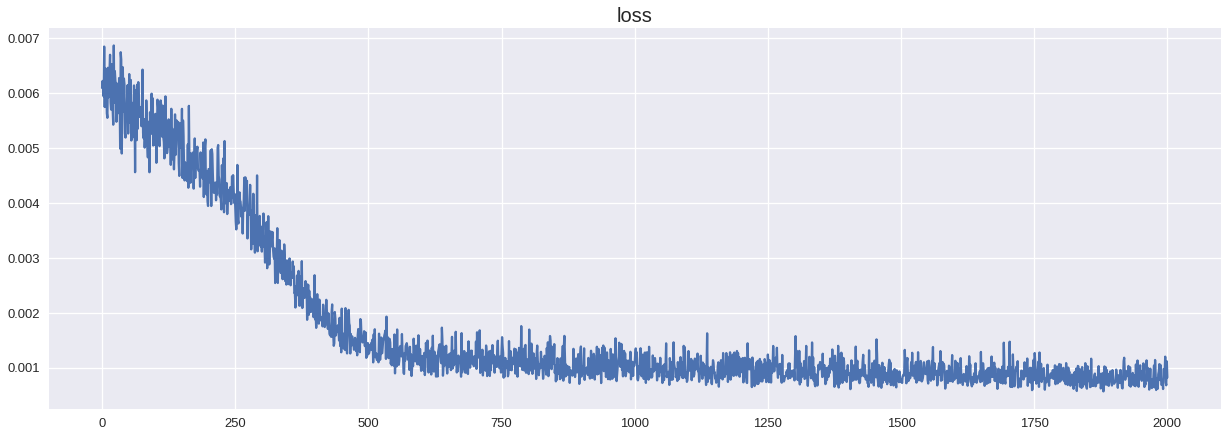

1

Epoch  0 loss  tensor(0.0030, device='cuda:0')

Epoch  1 loss  tensor(0.0035, device='cuda:0')

Epoch  2 loss  tensor(0.0025, device='cuda:0')

Epoch  3 loss  tensor(0.0026, device='cuda:0')

Epoch  4 loss  tensor(0.0019, device='cuda:0')

Epoch  5 loss  tensor(0.0022, device='cuda:0')

Epoch  6 loss  tensor(0.0019, device='cuda:0')

Epoch  7 loss  tensor(0.0017, device='cuda:0')

Epoch  8 loss  tensor(0.0017, device='cuda:0')

Epoch  9 loss  tensor(0.0014, device='cuda:0')

Epoch  10 loss  tensor(0.0012, device='cuda:0')

Epoch  11 loss  tensor(0.0011, device='cuda:0')

Epoch  12 loss  tensor(0.0008, device='cuda:0')
loss :  (tensor(0.0016, device='cuda:0'), [tensor(0.0030, device='cuda:0'), tensor(0.0035, device='cuda:0'), tensor(0.0025, device='cuda:0'), tensor(0.0026, device='cuda:0'), tensor(0.0019, device='cuda:0'), tensor(0.0022, device='cuda:0'), tensor(0.0019, device='cuda:0'), tensor(0.0017, device='cuda:0'), tensor(0.0017, device='cuda:0'), tensor(0.0014, device='cuda:0')

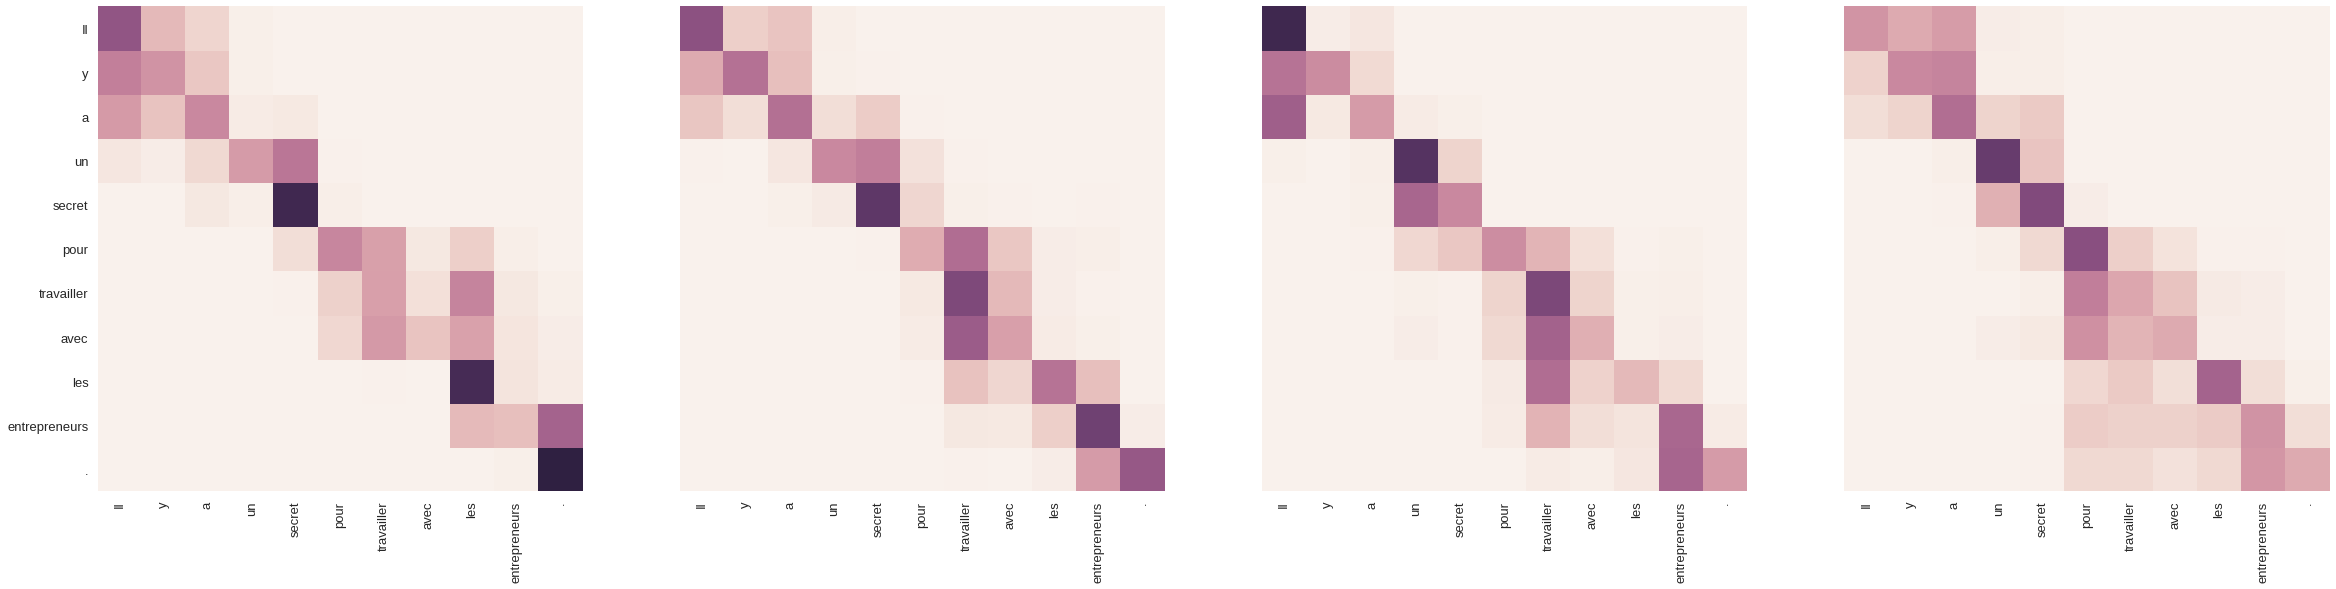

Encoder Layer 4


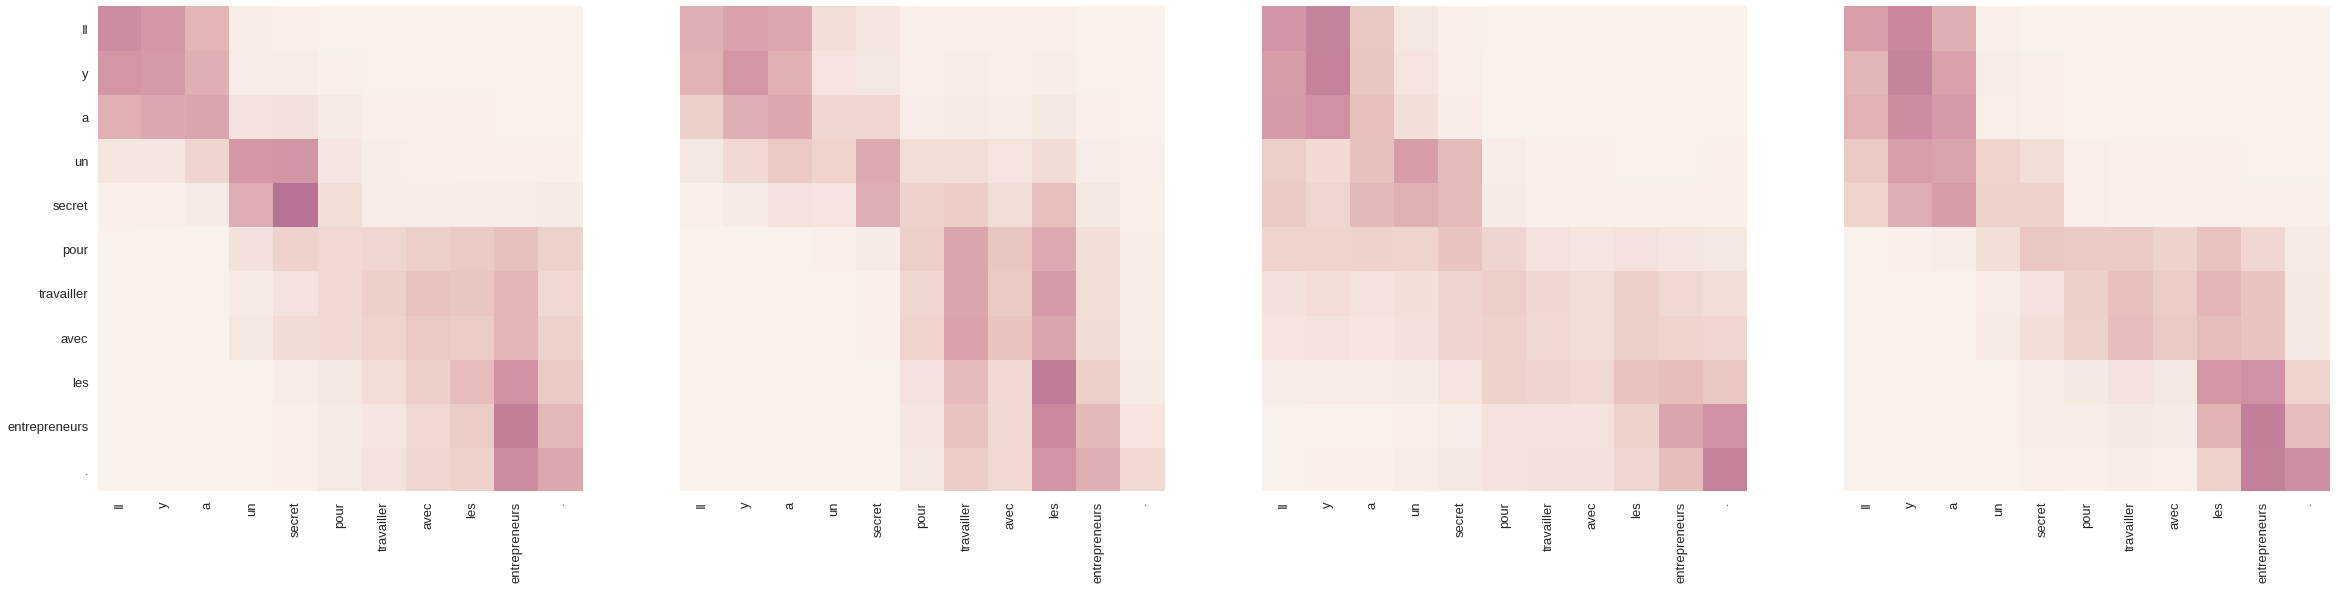

Encoder Layer 6


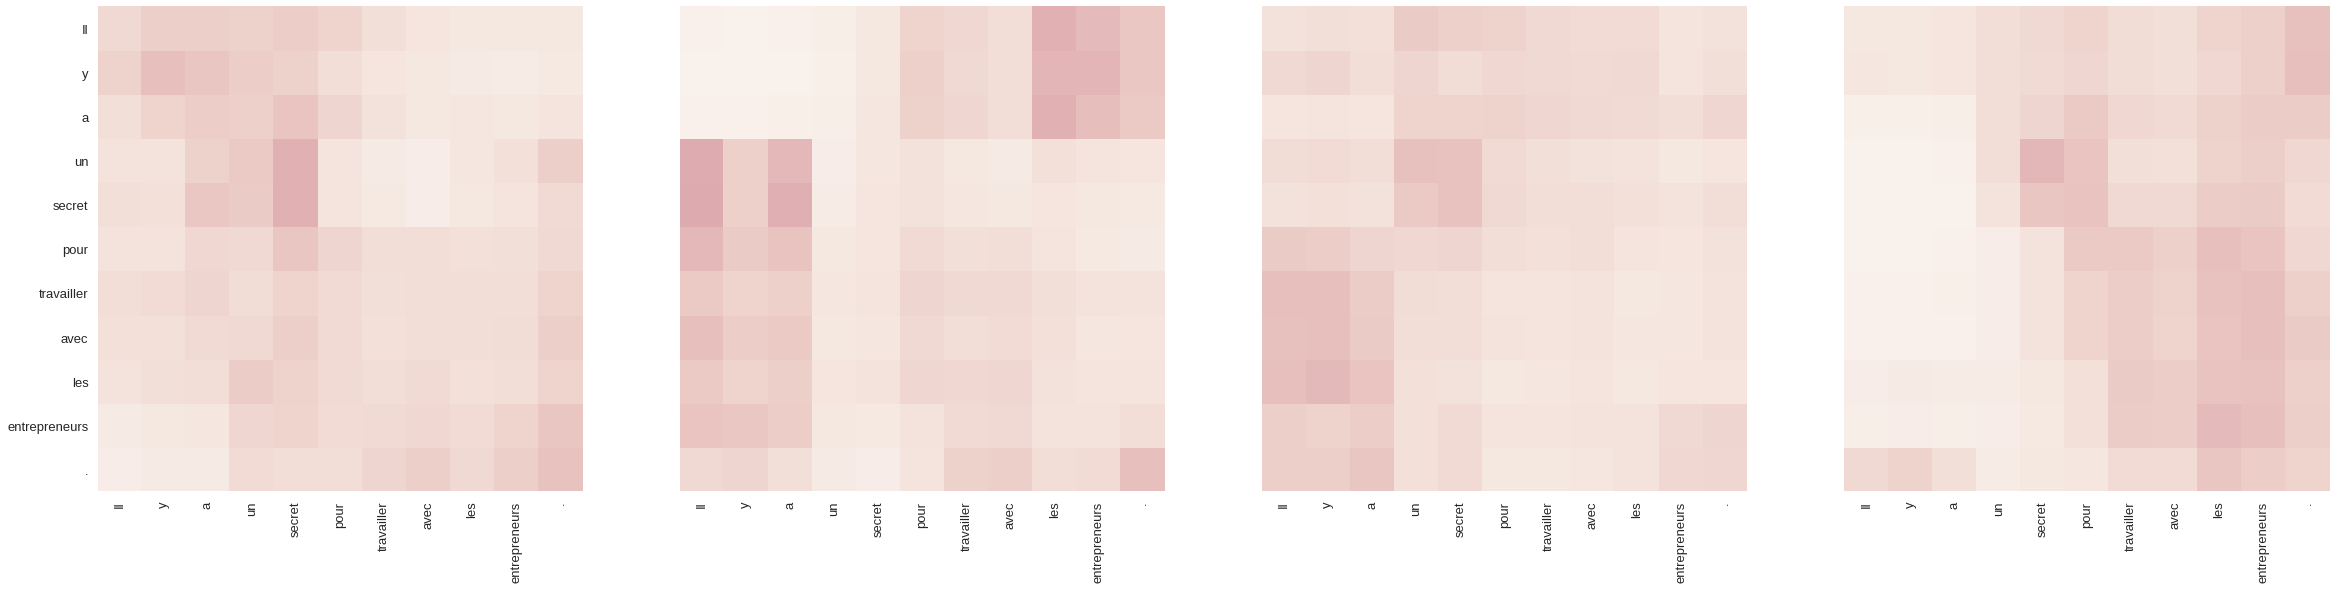

Decoder Self Layer 2


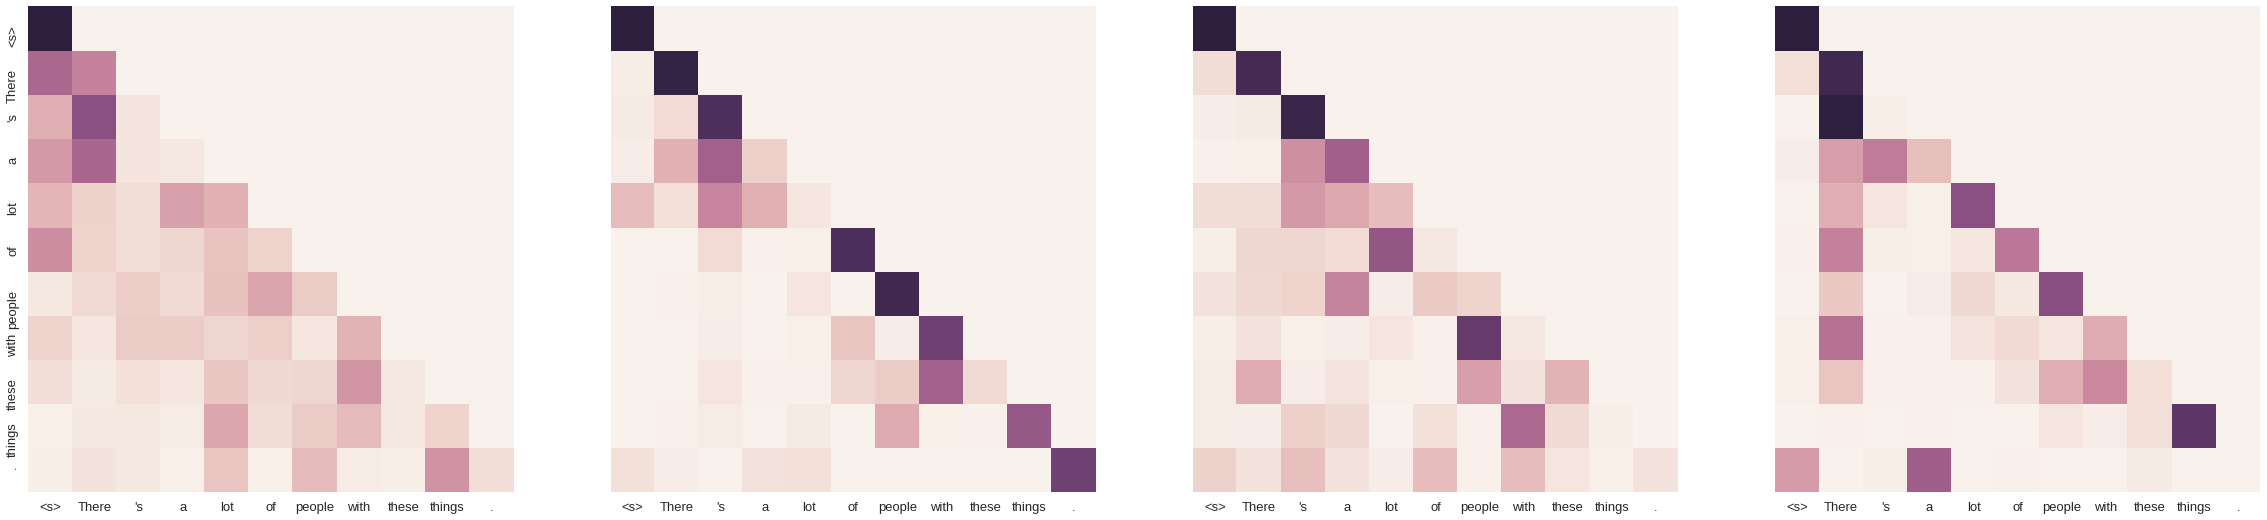

Decoder Self Layer 4


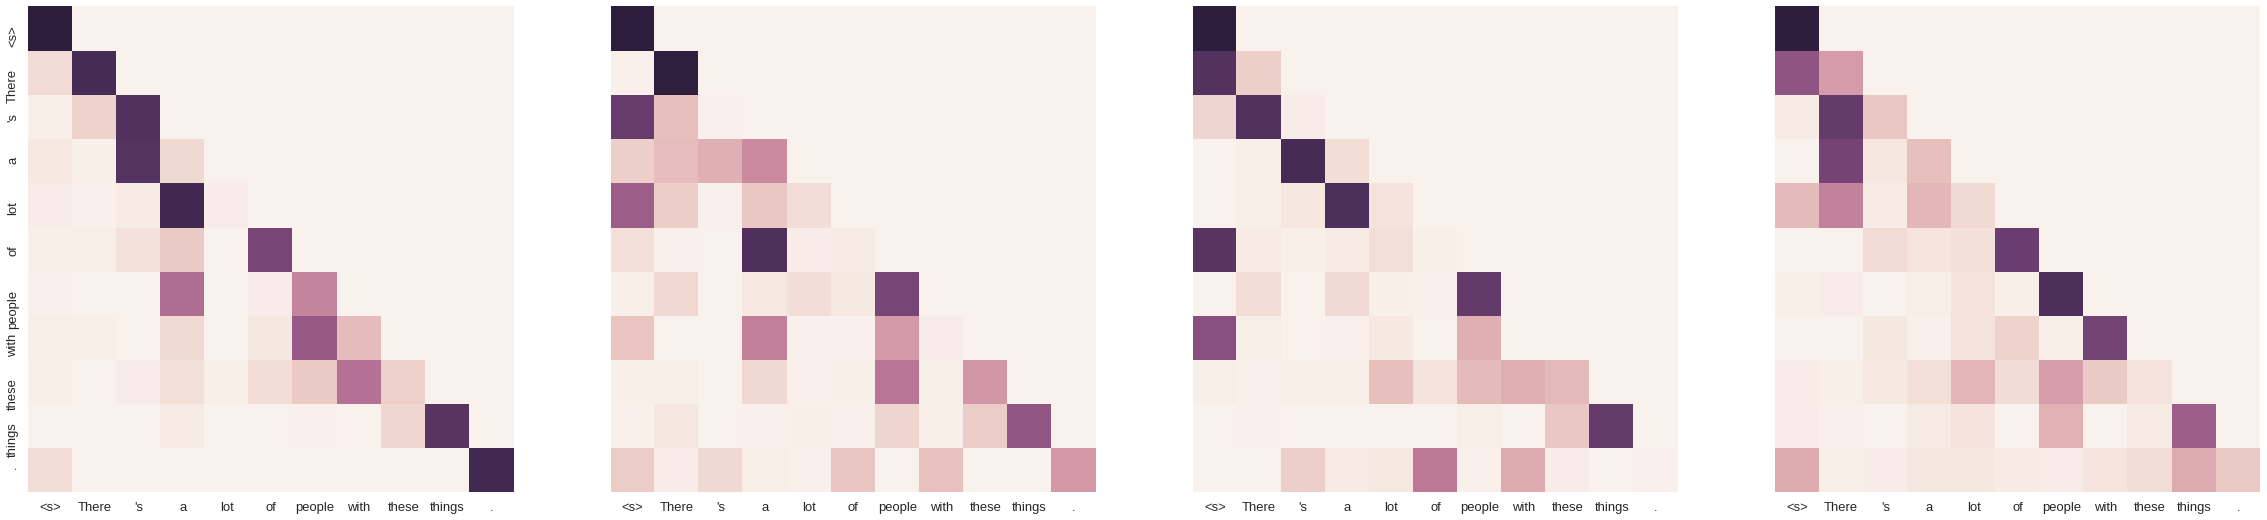

Decoder Self Layer 6


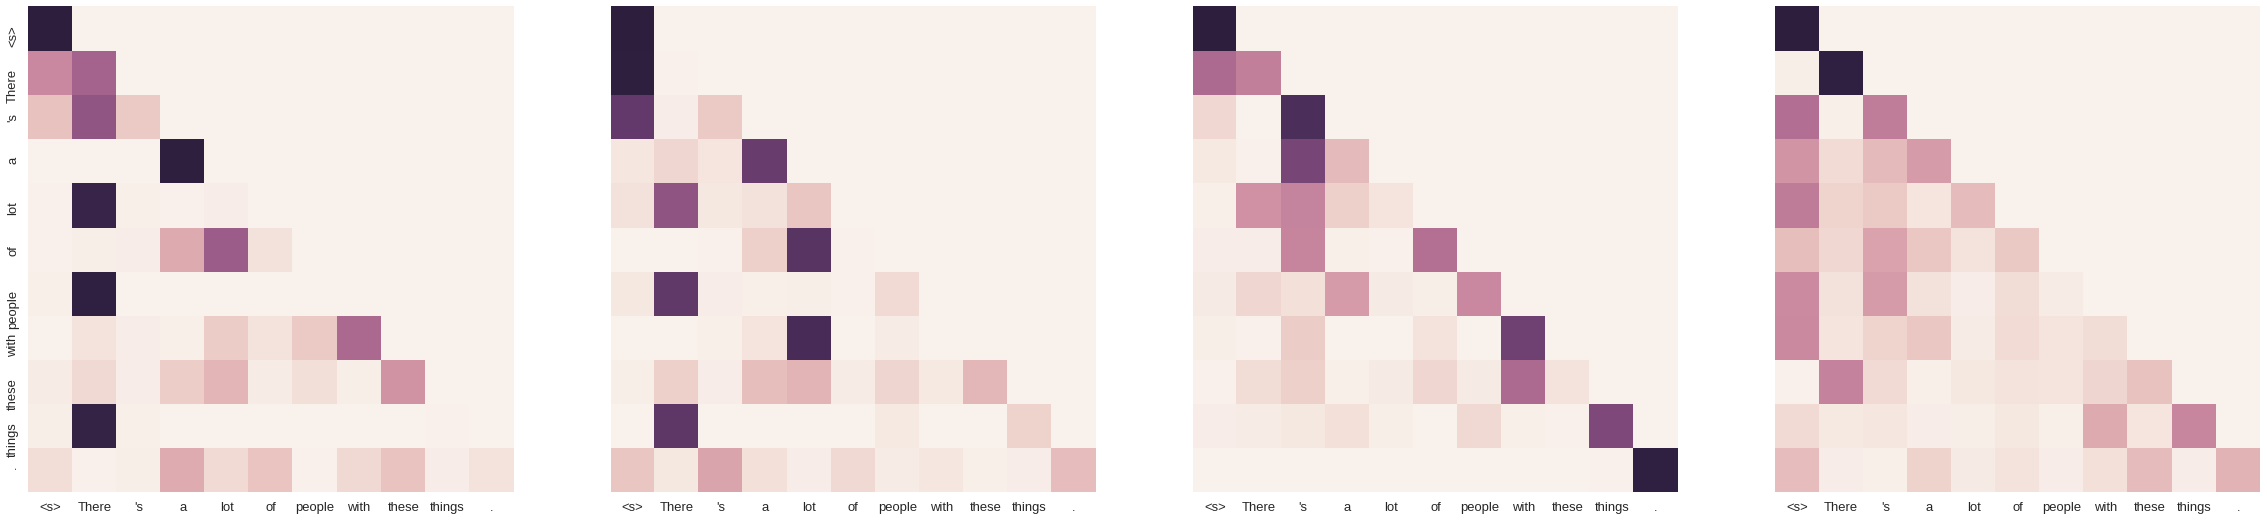

Decoder Src Layer 6


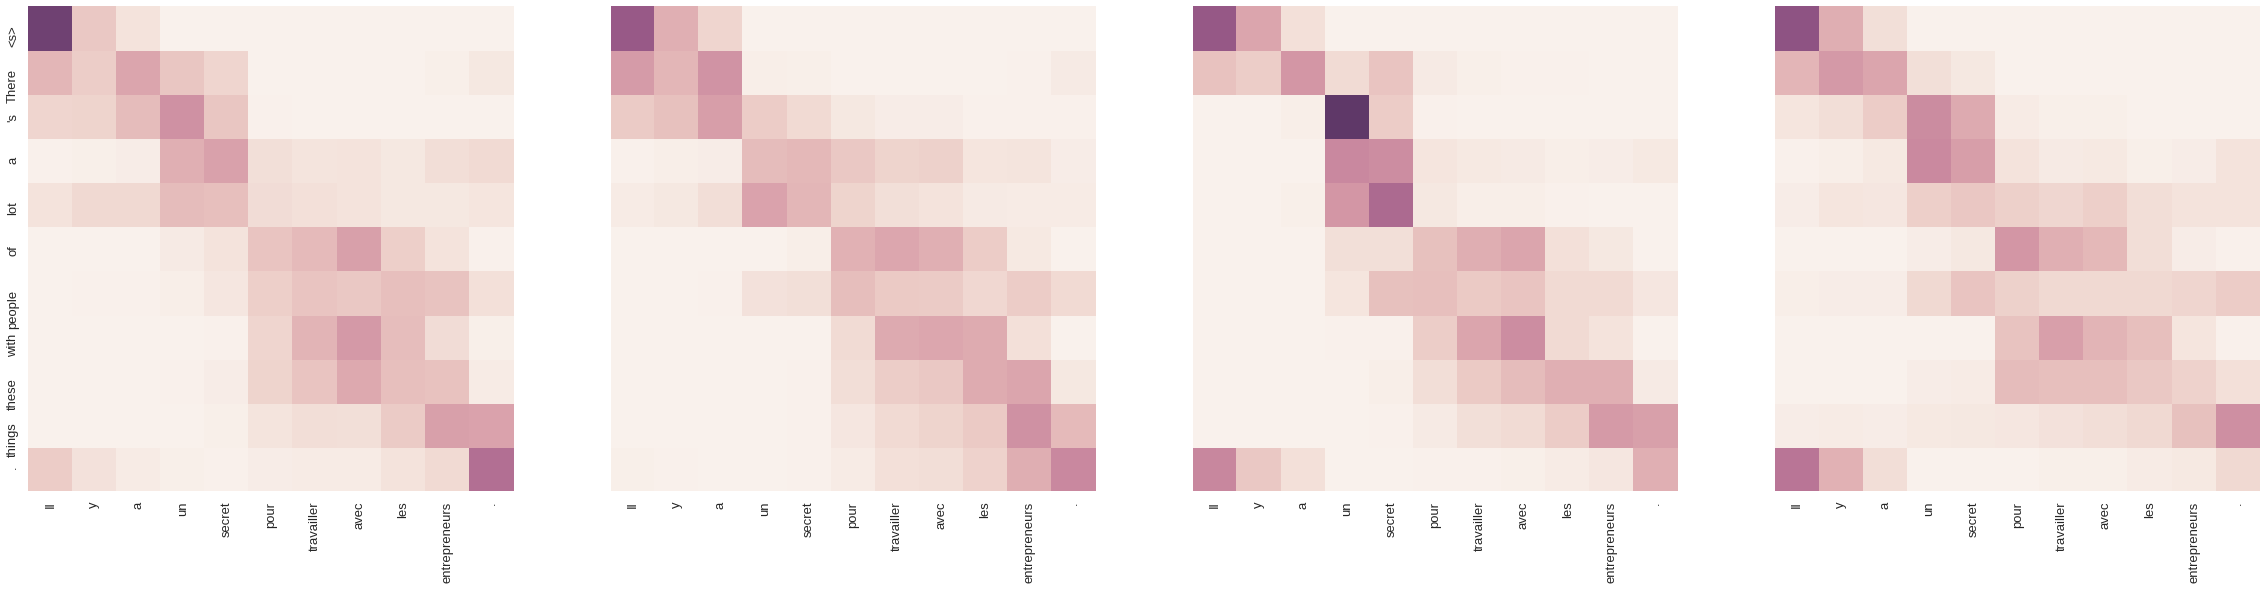

Saving network


FileNotFoundError: ignored

In [24]:
if not (justEvaluate) :
    print("Starting training")
    #training(model_par, model_opt, trainItNb, train_iter, valid_iter, validFreq, criterion, pad_idx, devices)
    #evaluate(model_par, valid_iter, criterion, devices, model_opt, pad_idx)
   
    training(model, model_opt, trainItNb, train_iter, valid_iter, validFreq, criterion, pad_idx, device)
    evaluate(model, valid_iter, criterion, device, model_opt, pad_idx, validItNb)

    print("Saving network")
    #saveModel(model_par, previousEpochNb + trainItNb, model_opt, BATCH_SIZE, modelSavePath)
    saveModel(model,model_opt, previousEpochNb + trainItNb, BATCH_SIZE, modelSavePath)
else :
    evaluate(model, valid_iter, criterion, device, model_opt, pad_idx,validItNb)
    #evaluate(model_par, valid_iter, criterion, devices, model_opt, pad_idx)


# Results here
